In [3]:
# for folder in os.listdir("Dataset"):
# #     print(folder)
#     x = folder.split('db')
#     folder_path = os.path.join('Dataset', folder)
# #     for subfolder in os.listdir(folder_path):
# #     subfolder_path = os.path.join(folder_path,subfolder)
#     for subfolder in os.listdir(folder_path):
#         subfolder_path = os.path.join(folder_path,subfolder)
#         if os.path.isdir(subfolder_path):
#             for sub_sub in os.listdir(subfolder_path):
#                 if os.path.isdir(os.path.join(subfolder_path, sub_sub)):
#                     for image in os.listdir(os.path.join(subfolder_path, sub_sub)):
#                         src= os.path.join(subfolder_path, sub_sub, image)
#                         dst = os.path.join(subfolder_path, sub_sub, x[1]+'_'+image)
#                         os.rename(src, dst)
                        
#                 src= os.path.join(subfolder_path, sub_sub)
#                 dst = os.path.join(subfolder_path, x[1]+'_'+sub_sub)
#                 os.rename(src, dst)

In [1]:
import os, glob
import sys
import copy 
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow import keras
from scipy.ndimage import rotate
plt.set_cmap('gray')
%matplotlib inline
## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = np.float
SEG_DTYPE = np.uint8


In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
# COUNT THE NUMBER OF SCANS FOR 1 PATIENT TO APPEND ON THEM
def count_scans_startwith(directory, prefix):
    count = 0
    for file in os.listdir(directory):
        if file.startswith(prefix+'_'):
            count+=1
    return count

In [5]:
# REFLECT IMAGE AND MASK TO AUGMENT DATA
def reflect_dicom(src_img, src_mask, src_liver_mask, train_path, masks_path, liver_mask_path, patient_id, patient_imgs_count, liver_write):
    reflected_img = copy.deepcopy(src_img)
    reflected_img.PixelData = np.fliplr(reflected_img.pixel_array).tobytes()
    
    if liver_write:
        reflected_liver_mask = copy.deepcopy(src_liver_mask)
        reflected_liver_mask.PixelData = np.fliplr(reflected_liver_mask.pixel_array).tobytes()
        reflected_liver_mask.save_as(os.path.join(liver_mask_path, patient_id+'_image_'+str(patient_imgs_count)+'_aug'))
            
    reflected_mask = copy.deepcopy(src_mask)
    reflected_mask.PixelData = np.fliplr(reflected_mask.pixel_array).tobytes()
    
   
    reflected_img.save_as(os.path.join(train_path, patient_id+'_image_'+str(patient_imgs_count)+'_aug'))
    reflected_mask.save_as(os.path.join(masks_path, patient_id+'_image_'+str(patient_imgs_count)+'_aug'))
    
# ROTATE IMAGE AND MASK TO AUGMENT DATA
def rotate_dicom(src_img, src_mask, src_liver_mask, train_path, masks_path, liver_mask_path, patient_id, patient_imgs_count, angle, liver_write):
    rotated_img = copy.deepcopy(src_img)
    rotated_img.PixelData = rotate(rotated_img.pixel_array, angle, reshape=False).tobytes()
    
    if liver_write:
        rotated_liver_mask = copy.deepcopy(src_liver_mask)
        rotated_liver_mask.PixelData = rotate(rotated_liver_mask.pixel_array, angle, reshape=False).tobytes()
        rotated_liver_mask.save_as(os.path.join(liver_mask_path, patient_id+'_image_'+str(patient_imgs_count)+'_aug'))
    
    rotated_mask = copy.deepcopy(src_mask)
    rotated_mask.PixelData = rotate(rotated_mask.pixel_array, angle, reshape=False).tobytes()
    

    rotated_img.save_as(os.path.join(train_path, patient_id+'_image_'+str(patient_imgs_count)+'_aug'))
    rotated_mask.save_as(os.path.join(masks_path, patient_id+'_image_'+str(patient_imgs_count)+'_aug'))

In [14]:
# DATA AUGMENTATION TO FIX CLASS IMBALANCING


def augment_dicom(train_path, masks_path):
    rotation_angles = [x * 15 for x in range(24) if x > 0]
    train_files = copy.deepcopy(os.listdir(train_path))
    mask_folders = copy.deepcopy(os.listdir(masks_path))
    for scan in train_files:
        patient_id = scan.split('_')[0]
        patient_imgs_count = count_scans_startwith(train_path, patient_id)
        original_img = pydicom.dcmread(os.path.join(train_path, scan)) 
        liver_mask_path = os.path.join(masks_path, patient_id+'_liver')
        liver_mask = pydicom.dcmread(os.path.join(liver_mask_path, scan))
        
        patient_tumors = []
        for mask in mask_folders:
            if mask.startswith(patient_id + '_livertumor'):
                original_mask = pydicom.dcmread(os.path.join(masks_path, mask, scan))
                patient_tumors.append(mask)
        
        patient_imgs_count += 1 if len(patient_tumors) > 0 else 0
        for index, tumor_mask in enumerate(patient_tumors):
            liver_write = index == 0
            masks_final_path = os.path.join(masks_path, tumor_mask)
            reflect_dicom(original_img, original_mask, liver_mask, train_path, masks_final_path, liver_mask_path, patient_id, patient_imgs_count, liver_write)
        
        for angle in rotation_angles:
            patient_imgs_count += 1
            for index, rotation_mask in enumerate(patient_tumors):
                liver_write = index == 0
                masks_final_path = os.path.join(masks_path, rotation_mask)
                rotate_dicom(original_img, original_mask, liver_mask, train_path, masks_final_path, liver_mask_path, patient_id, patient_imgs_count, angle, liver_write)  
                
            
#         for mask in mask_folders:
#             if mask.startswith(patient_id + '_livertumor'):
#                 original_mask = pydicom.dcmread(os.path.join(masks_path, mask, scan))
#                 masks_final_path = os.path.join(masks_path, mask)
#                 if 1 in original_mask.pixel_array:
#                     patient_imgs_count += 1
#                     reflect_dicom(original_img, original_mask, liver_mask, train_path, masks_final_path, liver_mask_path, patient_id, patient_imgs_count)
#                     for angle in rotation_angles:
#                         patient_imgs_count += 1
#                         rotate_dicom(original_img, original_mask, liver_mask, train_path, masks_final_path, liver_mask_path, patient_id, patient_imgs_count, angle)
                   
        
    
    

In [15]:
def mask_livertumors(scans_path, masks_path):
    for scan in os.listdir(scans_path):
        patient_id = scan.split('_')[0]
        tumor_volume = None
        for mask_dir in os.listdir(masks_path):
            if mask_dir.startswith(patient_id+'_livertumor'):
                current_tumor = pydicom.dcmread(os.path.join(masks_path, mask_dir, scan)).pixel_array
                current_tumor = current_tumor/255.0
                current_tumor = np.clip(current_tumor,0,1)
#                 if tumor_volume is not None:
#                     tumor_volume[current_tumor == 1 ] = 1
#                 else:
#                     tumor_volume = copy.deepcopy(current_tumor)
                tumor_volume = current_tumor if tumor_volume is None else np.logical_or(tumor_volume,current_tumor)
        
        temp = pydicom.dcmread('empty_dicom') 
        if tumor_volume is not None:
            temp.PixelData = tumor_volume.tobytes()
        temp.save_as(os.path.join(masks_path, 'merged_livertumors', scan))


In [16]:
masks_path = os.path.join('train','masks')
training_path = os.path.join('train','patients')

In [17]:
# augment_dicom(training_path, masks_path)
mask_livertumors(training_path, masks_path)
print('done')

done


In [20]:
# REMOVE AUGMENTED DATA
for scan in os.listdir(training_path):
    if scan.endswith('_aug'):
        os.remove(os.path.join(training_path,scan))
for mask in os.listdir(masks_path):
    if 'livertumor' in mask or '_liver' in mask:
        mask_path = os.path.join(masks_path, mask)
        for tumor in os.listdir(mask_path):
            if tumor.endswith('_aug'):
                os.remove(os.path.join(mask_path, tumor))
print('done')

done


In [139]:
def histeq(im,nbr_bins=256):

   #get image histogram
   imhist,bins = np.histogram(im.flatten(),nbr_bins)
   cdf = imhist.cumsum() #cumulative distribution function
   cdf = 255 * cdf / cdf[-1] #normalize

   #use linear interpolation of cdf to find new pixel values
   im2 = np.interp(im.flatten(),bins[:-1],cdf)

   return im2.reshape(im.shape), cdf

def histeq_processorcumsum() #cumulative distribution function
    cdf = 255 * cdf / (img):
    """Histogram equalization"""
    nbr_bins=256
    #get image histogram
    imhist,bins = np.histogram(img.flatten(),nbr_bins)
    cdf = imhist.cdf[-1] #normalize
    #use linear interpolation of cdf to find new pixel values
    original_shape = img.shape
    img = np.interp(img.flatten(),bins[:-1],cdf)
    img=img/255.0
    return img.reshape(original_shape)

In [47]:
# def read_dicom_series(directory, filepattern = "image_*"):
#     """ Reads a DICOM Series files in the given directory. 
#     Only filesnames matching filepattern will be considered"""
    
#     if not os.path.exists(directory) or not os.path.isdir(directory):
#         raise ValueError("Given directory does not exist or is a file : "+str(directory))
#     print ('\tRead Dicom',directory)
#     lstFilesDCM = natsort.natsorted(glob.glob(os.path.join(directory, filepattern)))
#     print ('\tLength dicom series',len(lstFilesDCM))
#     # Get ref file
#     RefDs = dicom.read_file(lstFilesDCM[0])
#     # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
#     ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
#     # The array is sized based on 'ConstPixelDims'
#     ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

#     # loop through all the DICOM files
#     for filenameDCM in lstFilesDCM:
#         # read the file
#         ds = dicom.read_file(filenameDCM)
#         # store the raw image data
#         ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

#     return ArrayDicom

# def read_liver_lesion_masks(masks_dirname):
#     """Since 3DIRCAD provides an individual mask for each tissue type (in DICOM series format),
#     we merge multiple tissue types into one Tumor mask, and merge this mask with the liver mask
    
#     Args:
#         masks_dirname : MASKS_DICOM directory containing multiple DICOM series directories, 
#                         one for each labelled mask
#     Returns:
#         numpy array with 0's for background pixels, 1's for liver pixels and 2's for tumor pixels
#     """
#     tumor_volume = None
#     liver_volume = None
    
#     # For each relevant organ in the current volume
#     for organ in os.listdir(masks_dirname):
#         organ_path = os.path.join(masks_dirname,organ)
#         if not os.path.isdir(organ_path):
#             continue
        
#         organ = organ.lower()
        
#         if organ.startswith("livertumor") or re.match("liver.yst.*", organ) or organ.startswith("stone") or organ.startswith("metastasecto") :
#             print('Organ',masks_dirname,organ)
#             current_tumor = read_dicom_series(organ_path)
#             current_tumor = np.clip(current_tumor,0,1)
#             # Merge different tumor masks into a single mask volume
#             tumor_volume = current_tumor if tumor_volume is None else np.logical_or(tumor_volume,current_tumor)
#         elif organ == 'liver':
#             print('Organ',masks_dirname,organ)
#             liver_volume = read_dicom_series(organ_path)
#             liver_volume = np.clip(liver_volume, 0, 1)
    
#     # Merge liver and tumor into 1 volume with background=0, liver=1, tumor=2
#     label_volume = np.zeros(liver_volume.shape)
#     label_volume[liver_volume==1]=1
#     label_volume[tumor_volume==1]=2
#     return label_volume    
            
def stat(array):
    print('min',np.min(array),'max',np.max(array),'median',np.median(array),'avg',np.mean(array))
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def to_scale(img, shape=None):

    height, width = shape
    if img.dtype == SEG_DTYPE:
        return scipy.misc.imresize(img,(height,width),interp="nearest").astype(SEG_DTYPE)
    elif img.dtype == IMG_DTYPE:
        max_ = np.max(img)
        factor = 255.0/max_ if max_ != 0 else 1
#         return (scipy.misc.imresize(img,(height,width),interp="nearest")/factor).astype(IMG_DTYPE)
        return np.array(Image.fromarray(img).resize([height, width])/factor).astype(IMG_DTYPE)
    else:
        raise TypeError('Error. To scale the image array, its type must be np.uint8 or np.float64. (' + str(img.dtype) + ')')


def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

In [107]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
#         print(self.path, id_name)
#         path = os.path.normpath(self.path)
#         x = path.split(os.sep)
        tumor_volume = None
        
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        image = step1_preprocess_img_slice(dicom_image.pixel_array)
        image = normalize_image(image)
        liver_mask_id = id_name.split('_')
        liver_mask = pydicom.dcmread(os.path.join(mask_path, liver_mask_id[0]+'_liver', id_name)).pixel_array
        
#         print(image)
        image[liver_mask == 0.0] = 0.0 
        mask = np.zeros((self.image_size, self.image_size, 1))
        for name in all_masks:
            y = id_name.split('_')
            if name.startswith(y[0] + '_livertumor'):
                current_tumor = pydicom.dcmread(os.path.join(mask_path, name, id_name)).pixel_array
                current_tumor = current_tumor/255.0
                current_tumor = np.clip(current_tumor,0,1)
                tumor_volume = current_tumor if tumor_volume is None else np.logical_or(tumor_volume,current_tumor)
 
        mask = np.zeros(liver_mask.shape)
        mask[tumor_volume==1]=1
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = mask[:, :, np.newaxis]
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
#         print(files_batch)
        image = []
        mask  = []
    
        for id_name in files_batch:
#             return len(files_batch)
            _img, _mask = self.__load__(id_name)
#             _img = _img.astype(np.uint8)
#             _img = cv2.cvtColor(_img,cv2.COLOR_GRAY2RGB)
#             _img = np.broadcast_to(_img[..., np.newaxis], (128, 128, 3))
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)
#         image = image[:, :, np.newaxis]
#         image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB) 

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


In [119]:
image_size = 128
train_path = "train"
batch_size = 8

## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):
#     if not (file.startswith("1.5") or file.startswith("1.7") or file.startswith("1.11") or file.startswith("1.14")or file.startswith("1.20")): 
    images.append(file)
print(len(images))


## Validation Data Size
val_data_size = 600

valid_ids = images[:val_data_size]
train_ids = images[val_data_size:]

epochs = len(train_ids)//batch_size

3414


In [109]:
# sample_weight = np.ones((len(train_ids),), dtype=int)

# for index, file_id in enumerate(train_ids):
#     patient_id = file_id.split('_')
#     all_tumors_dir = os.path.join(train_path, 'masks')
#     for tumor_dir in os.listdir(all_tumors_dir):
#         if tumor_dir.startswith(patient_id[0]+'_livertumor'):
#             tumor_mask = pydicom.dcmread(os.path.join(all_tumors_dir, tumor_dir, file_id)).pixel_array
#             if 1 in tumor_mask:
#                 sample_weight[index] = 50
        

In [110]:
# print(len(sample_weight[sample_weight > 1]))
# x = 1
# print(os.path.join('..','Dataset','3Dircadb'+str(x),'LABELLED_DICOM'))

In [111]:
def step1_preprocess_img_slice(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Rotate the input volume so the the liver is on the left, spine is at the bottom of the image
    2- Set pixels with hounsfield value great than 1200, to zero.
    3- Clip all hounsfield values to the range [-100, 400]
    4- Normalize values to [0, 1]
    5- Rescale img and label slices to 388x388
    6- Pad img slices with 92 pixels on all sides (so total shape is 572x572)
    
    Args:
        img_slc: raw image slice
    Return:
        Preprocessed image slice
    """      
    img_slc   = img_slc.astype(IMG_DTYPE)
    img_slc[img_slc>1200] = 0
#     img_slc = cv2.GaussianBlur(img_slc,(5,5),0)
    img_slc   = np.clip(img_slc, -160, 240)    
#     img_slc   = normalize_image(img_slc)
#     img_slc   = to_scale(img_slc, (388,388))
#     img_slc   = np.pad(img_slc,((62,62),(62,62)),mode='reflect')
    
#     img_slc   = img_slc[:, :, np.newaxis]
#     if False:
    
#     img_slc = histeq(img_slc)
#     img_slc = ImageEnhance.Contrast(img_slc)
#     img_slc = enhancer.enhance(4.0)
    

    return img_slc


In [112]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
# for i in range(0, len(y)):
#     for j in range(0, len(y[i])):
#         for k in range(0, len(y[i][j])):
#             if(y[i][j][k][0] > 0):
#                 print(y[i][j][k][0])
# # print(y)
# print(x.shape, y.shape)
# print(gen.__getitem__(0))

3


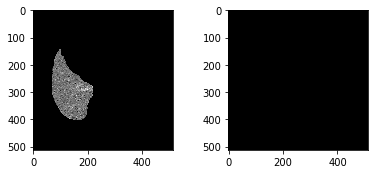

In [114]:
r = random.randint(0, len(x)-1)
# r=2
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [121]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [122]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [123]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"], sample_weight_mode='temporal')
# model.summary()

In [124]:
# sample_weight = []

# all_masks_path = os.path.join(train_path, "masks")
# for mask_dir in os.listdir(all_masks_path):
#     if mask_dir.endswith('livertumor') or mask_dir.endswith('livertumor01'):
#         weight = 1
#         full_mask_dir = os.path.join(all_masks_path,mask_dir)
#         for mask_path in os.listdir(full_mask_dir):
#             mask = pydicom.dcmread(os.path.join(full_mask_dir,mask_path)).pixel_array
#             value = 20 if 1 in mask else 1
#             sample_weight.append(value)
# #     else:
# #         sample_weight.append(0)


In [143]:
# os.environ ['CUDA_VISIBLE_DEVICES'] = '1' 
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size
# # with tf.device('/gpu:0'):
# class_weight = {0 : 1. , 1: 50.}

model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/351
 16/351 [>.............................] - ETA: 54s - loss: 0.0308 - acc: 0.9981

StopIteration: [Errno 2] No such file or directory: 'train/masks/1.8_livertumor03/1.8_image_144_aug'

In [ ]:
# training_generator, steps_per_epoch = balanced_batch_generator(train_gen, y, sampler=NearMiss(), batch_size=10, random_state=42)

In [41]:
# model.save('tumor_cnn.h5')  # creates a HDF5 file 'my_model.h5'

model = keras.models.load_model('tumor_cnn.h5')
model.summary()

## del model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

False


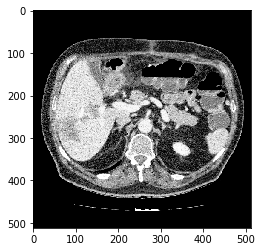

1164


In [188]:
img_53 = pydicom.dcmread('train/patients/1.6_image_80').pixel_array
img_53 = step1_preprocess_img_slice(img_53)
img_53 = normalize_image(img_53)
imshow(img_53)
for index, image in enumerate(train_ids):
    if image == "1.6_image_80":
        print(index)

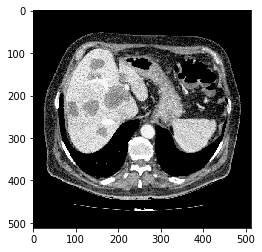

In [189]:
x, y = gen.__getitem__(80)
imshow(x[0])

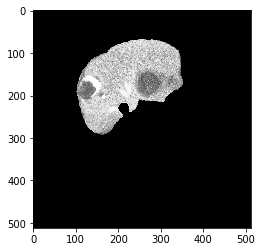

In [45]:
x, y = valid_gen.__getitem__(17)

result = model.predict(x)

result = result > 0.5
# print(x.shape, result.shape)
# for i in range(0, len(y)):
#     for j in range(0, len(y[i])):
#         for k in range(0, len(y[i][j])):
#             x[i][j][k][0] = x[i][j][k][0] if result[i][j][k][0] else 0
#             x[i][j][k][1] = x[i][j][k][1] if result[i][j][k][0] else 0
#             x[i][j][k][2] = x[i][j][k][2] if result[i][j][k][0] else 0
imshow(x[1])
# print(len(result), result.shape)
# print(x.shape, result.shape)
# for i in range(0, len(y)):
#     for j in range(0, len(y[i])):
#         for k in range(0, len(y[i][j])):
#             if result[i][j][k][0] > 0 or y[i][j][k][0] > 0:
#                 print(result[i][j][k][0], y[i][j][k][0])


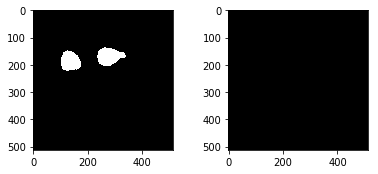

In [46]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")